In [4]:
import os
import cv2
import numpy as np

def load_utk_faces(folder_path, image_size=(160, 160), max_samples=1000):
    images = []
    labels = []

    def extract_identity(fname):
        return "_".join(fname.split("_")[:2])  # e.g., "1_1" from "1_1_rot_neg20.jpg"

    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])

    for i, filename in enumerate(image_files):
        if i >= max_samples:
            break

        path = os.path.join(folder_path, filename)
        img = cv2.imread(path)
        if img is None:
            continue

        # Preprocessing for FaceNet
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        identity_label = extract_identity(filename)

        images.append(img)
        labels.append(identity_label)

    return np.array(images), labels


In [5]:
print("📂 All files in folder:")
print(os.listdir("./combined_faces_train_augmented"))


📂 All files in folder:
['content']


In [6]:
images, labels = load_utk_faces("./combined_faces_train_augmented/content/combined_faces_train_augmented")
print(labels)
# ['1_1', '1_1', '1_2', '1_2']


['100_10.jpg', '100_10', '100_10', '100_10', '100_10', '100_10', '100_10', '100_10', '100_10', '100_10', '100_12.jpg', '100_12', '100_12', '100_12', '100_12', '100_12', '100_12', '100_12', '100_12', '100_12', '100_13.jpg', '100_13', '100_13', '100_13', '100_13', '100_13', '100_13', '100_13', '100_13', '100_13', '100_2.jpg', '100_2', '100_2', '100_2', '100_2', '100_2', '100_2', '100_2', '100_2', '100_2', '100_5.jpg', '100_5', '100_5', '100_5', '100_5', '100_5', '100_5', '100_5', '100_5', '100_5', '100_7.jpg', '100_7', '100_7', '100_7', '100_7', '100_7', '100_7', '100_7', '100_7', '100_7', '100_8.jpg', '100_8', '100_8', '100_8', '100_8', '100_8', '100_8', '100_8', '100_8', '100_8', '100_9.jpg', '100_9', '100_9', '100_9', '100_9', '100_9', '100_9', '100_9', '100_9', '100_9', '101_1.jpg', '101_1', '101_1', '101_1', '101_1', '101_1', '101_1', '101_1', '101_1', '101_1', '101_2.jpg', '101_2', '101_2', '101_2', '101_2', '101_2', '101_2', '101_2', '101_2', '101_2', '101_3.jpg', '101_3', '101_3'

In [7]:
from face_recognition.facenet_model import FaceNetEmbedder
import uuid

# Initialize FaceNet
facenet = FaceNetEmbedder()

# Load UTKFace data (from previous step)
image_folder = "./combined_faces_train_augmented/content/combined_faces_train_augmented"
images, label_seeds = load_utk_faces(image_folder, max_samples=100)

# Store embeddings and UIDs
embeddings = []
uids = []

for i, img in enumerate(images):
    uid = f"user_{label_seeds[i]}_{uuid.uuid4().hex[:6]}"
    emb = facenet.get_embedding(img)
    embeddings.append(emb)
    uids.append(uid)
    print(f"✅ Embedded {uid} → embedding[:5]: {emb[:5]}")



✅ FaceNet model loaded with 448 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Embedded user_100_10.jpg_1eff91 → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
✅ Embedded user_100_10_9956ef → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
✅ Embedded user_100_10_8bc80a → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ Embedded user_100_10_335971 → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
✅ Embedded user_100_10_f57f53 → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ Embedded user_100_10_48f68d → embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
✅ Embedded user_100_10_543336 → embed

In [8]:
len(embeddings)

100

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert to numpy arrays
embeddings = np.array(embeddings)
uids = np.array(uids)

# Initialize scores
same_person_scores = []
diff_person_scores = []

# Check pairwise similarity (just for first few pairs)
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]

        # Same label check using label_seeds (age_gender_race)
        if label_seeds[i] == label_seeds[j]:
            same_person_scores.append(sim)
            print(f"🟢 SAME: {uids[i]} vs {uids[j]} → {sim:.4f}")
        else:
            diff_person_scores.append(sim)
            print(f"🔴 DIFF: {uids[i]} vs {uids[j]} → {sim:.4f}")

# Summary
print("\n📊 Summary Stats:")
print(f"✅ Avg similarity (same person): {np.mean(same_person_scores):.4f}")
print(f"❌ Avg similarity (different person): {np.mean(diff_person_scores):.4f}")


🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_9956ef → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_8bc80a → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_335971 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_f57f53 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_48f68d → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_543336 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_e72457 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_c2290c → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_10_aa70f7 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12.jpg_8da119 → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_1917fc → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_784fbb → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_860d6b → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_ed8d9f → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_e73d6f → 1.0000
🔴 DIFF: user_100_10.jpg_1eff91 vs user_100_12_161579 → 1.0000
🔴 DI

In [10]:
import numpy as np
import cv2
from keras_facenet import FaceNet

class FaceNetEmbedder:
    def __init__(self):
        print("✅ Initializing FaceNet...")
        self.model = FaceNet()
        print("✅ FaceNet loaded with", len(self.model.model.layers), "layers.")

    def get_embedding(self, img):
        # Resize and normalize image to 160x160 for FaceNet
        resized = cv2.resize(img, (160, 160))
        normalized = resized.astype("float32") / 255.0
        face_array = np.expand_dims(normalized, axis=0)  # (1, 160, 160, 3)
        embedding = self.model.embeddings(face_array)
        return embedding[0]


In [11]:
# Load any two visibly different face images
img1 = images[0]
img2 = images[9]

# Get embeddings
facenet=FaceNetEmbedder()
emb1 = facenet.get_embedding(img1)
emb2 = facenet.get_embedding(img2)

# Print first few dimensions
print("Embedding 1 ([:5]):", emb1[:5])
print("Embedding 2 ([:5]):", emb2[:5])

# Compute cosine similarity
sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
print(f"🔁 Cosine Similarity (img0 vs img5): {sim:.4f}")


✅ Initializing FaceNet...
✅ FaceNet loaded with 448 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Embedding 1 ([:5]): [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
Embedding 2 ([:5]): [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
🔁 Cosine Similarity (img0 vs img5): 1.0000


In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import tensorflow as tf

def build_cnn_embedding_model(input_shape=(160, 160, 3), embedding_dim=128):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(embedding_dim, activation='linear', name='embedding')(x)

    model = Model(inputs, x)
    return model
cnn_embedder = build_cnn_embedding_model()

In [13]:
import tensorflow.keras.backend as K

def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0:128], y_pred[:, 128:256], y_pred[:, 256:]
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        neg_dist = K.sum(K.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        return K.mean(K.maximum(basic_loss, 0.0))
    return loss


In [14]:
import random

def generate_triplets(images, labels, embedding_size=128):
    triplets = []

    label_to_images = {}
    for img, label in zip(images, labels):
        label_to_images.setdefault(label, []).append(img)

    unique_labels = list(label_to_images.keys())

    for label in unique_labels:
        if len(label_to_images[label]) < 2:
            continue

        pos_imgs = label_to_images[label]
        anchor_img = random.choice(pos_imgs)
        positive_img = random.choice([img for img in pos_imgs if not np.array_equal(img, anchor_img)])

        neg_label = random.choice([l for l in unique_labels if l != label])
        negative_img = random.choice(label_to_images[neg_label])

        triplets.append([anchor_img, positive_img, negative_img])

    X = np.array([np.concatenate([a, p, n], axis=2) for a, p, n in triplets])
    y = np.zeros((len(triplets),))  # Dummy output
    return X, y


In [15]:
embedding_model = build_cnn_embedding_model()
input_layer = Input(shape=(160, 160, 9))  # Concatenated A+P+N (3*3 channels)

# Split input into 3 parts
anchor = tf.keras.layers.Lambda(lambda x: x[:, :, :, :3])(input_layer)
positive = tf.keras.layers.Lambda(lambda x: x[:, :, :, 3:6])(input_layer)
negative = tf.keras.layers.Lambda(lambda x: x[:, :, :, 6:])(input_layer)

# Generate embeddings
anchor_emb = embedding_model(anchor)
positive_emb = embedding_model(positive)
negative_emb = embedding_model(negative)

merged = tf.keras.layers.Concatenate()([anchor_emb, positive_emb, negative_emb])
triplet_net = Model(input_layer, merged)
triplet_net.compile(loss=triplet_loss(margin=0.5), optimizer='adam')


In [16]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def get_cnn_embedding(model, img):
    img_resized = cv2.resize(img, (160, 160))
    img_array = img_resized.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    embedding = model.predict(img_array, verbose=0)[0]
    return embedding


In [17]:
embeddings = []
uids = []

for i, img in enumerate(images):
    uid = f"user_{label_seeds[i]}_{uuid.uuid4().hex[:6]}"
    emb = get_cnn_embedding(cnn_embedder, img)
    embeddings.append(emb)
    uids.append(uid)
    print(f"✅ {uid} → Embedding[:5]: {emb[:5]}")


✅ user_100_10.jpg_a956e1 → Embedding[:5]: [-0.16740677 -0.26851276 -0.07525077  0.12304168  0.10491644]
✅ user_100_10_882686 → Embedding[:5]: [-0.18001817 -0.26419252 -0.10619746  0.10857332  0.08694866]
✅ user_100_10_0af313 → Embedding[:5]: [-0.17006263 -0.2804241  -0.07992218  0.08763049  0.08334173]
✅ user_100_10_6a7c00 → Embedding[:5]: [-0.16504574 -0.29091537 -0.07100743  0.10258813  0.09520194]
✅ user_100_10_5e8d0b → Embedding[:5]: [-0.2386894  -0.26321024 -0.10048928  0.06810474  0.0395534 ]
✅ user_100_10_02f160 → Embedding[:5]: [-0.19316663 -0.28576285 -0.08684009  0.0915106   0.06627969]
✅ user_100_10_498b91 → Embedding[:5]: [-0.1755698  -0.30146965 -0.06123378  0.111057    0.11123485]
✅ user_100_10_3fb589 → Embedding[:5]: [-0.16270685 -0.30957156 -0.03012618  0.09385156  0.11262992]
✅ user_100_10_9188a5 → Embedding[:5]: [-0.18319693 -0.2768567  -0.08545312  0.10389898  0.07377242]
✅ user_100_10_1db913 → Embedding[:5]: [-0.16384624 -0.29974666 -0.08789944  0.11209035  0.117143

In [18]:
from collections import defaultdict

grouped_embeddings = defaultdict(list)

for uid, emb in zip(uids, embeddings):
    seed = uid.split("_")[1]  # e.g., "user_100_abc123" → "100"
    grouped_embeddings[seed].append((uid, emb))


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import itertools

same_scores = []
diff_scores = []

seeds = list(grouped_embeddings.keys())

# SAME PERSON comparisons
print("🟢 SAME PERSON SIMILARITIES:")
for seed in seeds:
    pairs = list(itertools.combinations(grouped_embeddings[seed], 2))
    for (uid1, emb1), (uid2, emb2) in pairs:
        score = cosine_similarity([emb1], [emb2])[0][0]
        same_scores.append(score)
        print(f"✅ {uid1} vs {uid2} → Similarity: {score:.4f}")

# DIFFERENT PERSON comparisons (first item from each group)
print("\n🔴 DIFFERENT PERSON SIMILARITIES:")
for i in range(len(seeds)):
    for j in range(i + 1, len(seeds)):
        uid1, emb1 = grouped_embeddings[seeds[i]][0]
        uid2, emb2 = grouped_embeddings[seeds[j]][0]
        score = cosine_similarity([emb1], [emb2])[0][0]
        diff_scores.append(score)
        print(f"❌ {uid1} vs {uid2} → Similarity: {score:.4f}")


🟢 SAME PERSON SIMILARITIES:
✅ user_100_10.jpg_a956e1 vs user_100_10_882686 → Similarity: 0.9526
✅ user_100_10.jpg_a956e1 vs user_100_10_0af313 → Similarity: 0.9474
✅ user_100_10.jpg_a956e1 vs user_100_10_6a7c00 → Similarity: 0.9503
✅ user_100_10.jpg_a956e1 vs user_100_10_5e8d0b → Similarity: 0.9139
✅ user_100_10.jpg_a956e1 vs user_100_10_02f160 → Similarity: 0.8928
✅ user_100_10.jpg_a956e1 vs user_100_10_498b91 → Similarity: 0.9731
✅ user_100_10.jpg_a956e1 vs user_100_10_3fb589 → Similarity: 0.9484
✅ user_100_10.jpg_a956e1 vs user_100_10_9188a5 → Similarity: 0.9719
✅ user_100_10.jpg_a956e1 vs user_100_10_1db913 → Similarity: 0.9575
✅ user_100_10.jpg_a956e1 vs user_100_12.jpg_6bfad8 → Similarity: 0.9461
✅ user_100_10.jpg_a956e1 vs user_100_12_40ecbc → Similarity: 0.9314
✅ user_100_10.jpg_a956e1 vs user_100_12_487ee2 → Similarity: 0.9303
✅ user_100_10.jpg_a956e1 vs user_100_12_4cdaf5 → Similarity: 0.9337
✅ user_100_10.jpg_a956e1 vs user_100_12_90eb8b → Similarity: 0.9320
✅ user_100_10.jp

In [20]:
from face_recognition.facenet_model import FaceNetEmbedder
import uuid
import numpy as np

# Re-initialize FaceNet
facenet = FaceNetEmbedder()

embeddings = []
uids = []

for i, img in enumerate(images):
    uid = f"user_{label_seeds[i]}_{uuid.uuid4().hex[:6]}"
    emb = facenet.get_embedding(img)
    embeddings.append(emb)
    uids.append(uid)
    print(f"✅ {uid} → Embedding[:5]: {emb[:5]}")


✅ FaceNet model loaded with 448 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ user_100_10.jpg_41deab → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
✅ user_100_10_d563ad → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
✅ user_100_10_f2bcfd → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ user_100_10_81d096 → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
✅ user_100_10_1b0c41 → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
✅ user_100_10_6c75f7 → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
✅ user_100_10_c26fde → Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00

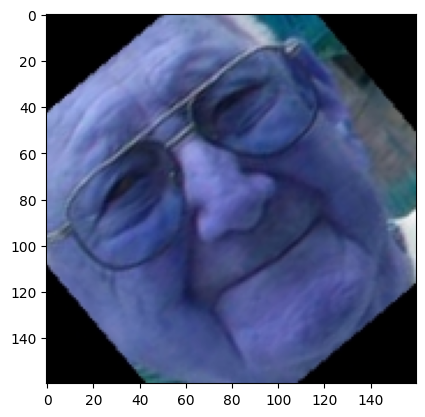

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img)  # Any sample image from your list
plt.show()


In [22]:
print(img.shape)  # Should be (160, 160, 3)


(160, 160, 3)


In [23]:
normalized = img.astype('float32') / 255.0
normalized

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

Image 0 - shape: (160, 160, 3) - dtype: uint8 - min: 0 - max: 251


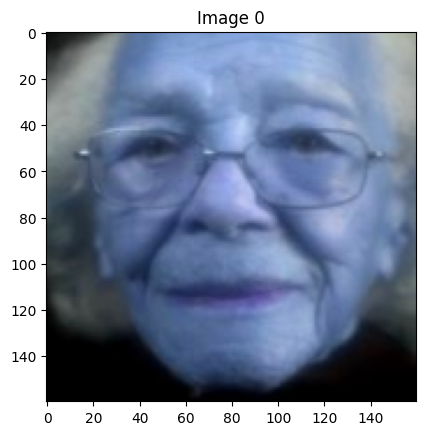

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
Image 1 - shape: (160, 160, 3) - dtype: uint8 - min: 0 - max: 251


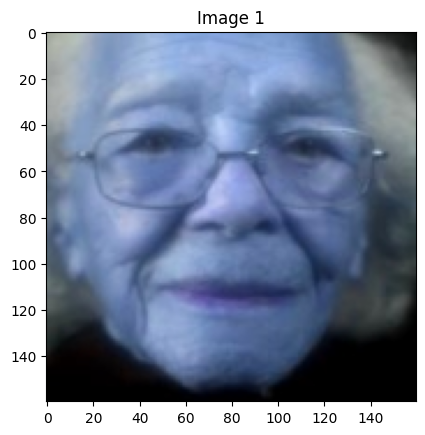

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
Image 2 - shape: (160, 160, 3) - dtype: uint8 - min: 0 - max: 252


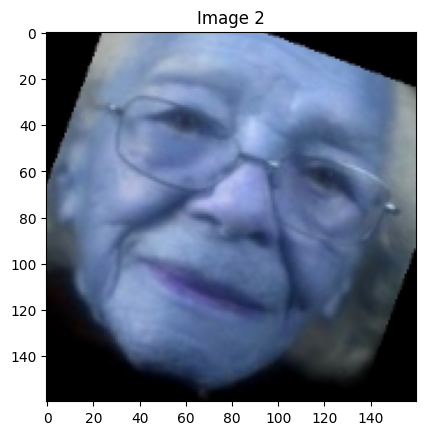

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
Image 3 - shape: (160, 160, 3) - dtype: uint8 - min: 0 - max: 251


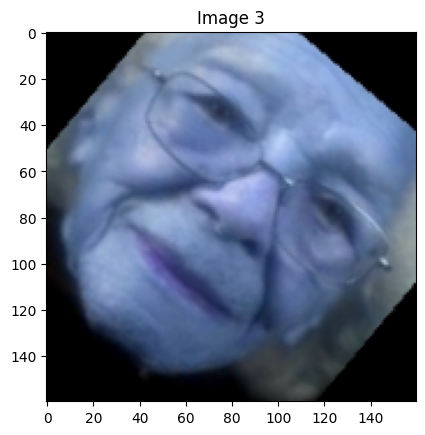

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]
Image 4 - shape: (160, 160, 3) - dtype: uint8 - min: 0 - max: 252


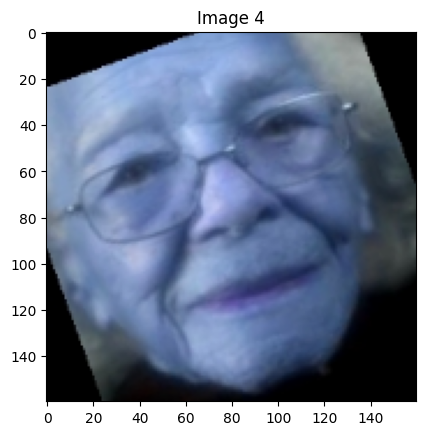

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]


In [24]:
from matplotlib import pyplot as plt

for i, img in enumerate(images[:5]):
    print(f"Image {i} - shape: {img.shape} - dtype: {img.dtype} - min: {img.min()} - max: {img.max()}")
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.show()

    # Get embedding from FaceNet
    emb = facenet.get_embedding(img)
    print(f"Embedding[:5]: {emb[:5]}")


In [25]:
dummy = np.random.rand(160, 160, 3).astype('float32')
embedding = facenet.get_embedding(dummy)
print("Dummy Embedding[:5]:", embedding[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Dummy Embedding[:5]: [ 0.01040817  0.01323741 -0.08136159  0.03703693 -0.00583533]


In [26]:
pip install facenet-pytorch


  Using cached pillow-10.2.0-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
Using cached pillow-10.2.0-cp312-cp312-win_amd64.whl (2.6 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [27]:
pip install pillow==9.5.0


  Using cached Pillow-9.5.0-cp312-cp312-win_amd64.whl.metadata (9.7 kB)
Using cached Pillow-9.5.0-cp312-cp312-win_amd64.whl (2.5 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.5.0 which is incompatible.


In [28]:
import torch
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1

class TorchFaceNetEmbedder:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        print(f"✅ Loading FaceNet (PyTorch) on {device}...")
        self.model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        self.device = device
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    def get_embedding(self, image_np):
        img_tensor = self.transform(image_np).unsqueeze(0).to(self.device)
        with torch.no_grad():
            embedding = self.model(img_tensor).cpu().numpy()[0]
        return embedding


In [29]:
from PIL import Image
import numpy as np

img = np.ones((160, 160, 3), dtype=np.uint8) * 255  # Dummy white image
Image.fromarray(img).show()  # If this works, Pillow is fixed


In [30]:
import uuid

# Initialize FaceNet Embedder
facenet = TorchFaceNetEmbedder()

# Generate embeddings and associate UIDs
embeddings = []
uids = []

for i, img in enumerate(images):  # images from UTKFace already preprocessed
    uid = f"user_{label_seeds[i]}_{uuid.uuid4().hex[:6]}"
    emb = facenet.get_embedding(img)
    embeddings.append(emb)
    uids.append(uid)
    print(f"✅ {uid} → embedding[:5]: {emb[:5]}")


✅ Loading FaceNet (PyTorch) on cpu...
✅ user_100_10.jpg_967d5c → embedding[:5]: [ 0.06170159 -0.0053166   0.03412578  0.03219411 -0.05003652]
✅ user_100_10_987a96 → embedding[:5]: [ 0.07198086 -0.01330322  0.02692079  0.03509507 -0.04817799]
✅ user_100_10_854397 → embedding[:5]: [ 0.06618641  0.02015416  0.00729073  0.01921368 -0.04304673]
✅ user_100_10_113dd9 → embedding[:5]: [ 0.0869313   0.00564576 -0.04936043  0.0030685  -0.04469981]
✅ user_100_10_594446 → embedding[:5]: [ 0.07447485 -0.03659024  0.00277658  0.02021994 -0.06059016]
✅ user_100_10_672a73 → embedding[:5]: [ 0.0549089   0.00128629 -0.04693981  0.00335979 -0.0430926 ]
✅ user_100_10_28303e → embedding[:5]: [ 0.06616943 -0.01288582  0.0193368   0.01263312 -0.04535296]
✅ user_100_10_7cadee → embedding[:5]: [ 0.0804149   0.00405512 -0.01785071  0.01231787 -0.0332686 ]
✅ user_100_10_ecaa80 → embedding[:5]: [ 0.08459625  0.00429492 -0.00322809  0.0151969  -0.04341832]
✅ user_100_10_dc287f → embedding[:5]: [ 0.08353333  0.0237

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Group embeddings by UID prefix (same user)
user_groups = {}
for uid, emb in zip(uids, embeddings):
    prefix = uid.split('_')[1]  # e.g. '100' in 'user_100_10'
    user_groups.setdefault(prefix, []).append((uid, emb))

# Compare within and across groups
same_person_scores = []
diff_person_scores = []

user_ids = list(user_groups.keys())
for i in range(len(user_ids)):
    uid1, group1 = user_ids[i], user_groups[user_ids[i]]
    for j in range(len(group1)):
        for k in range(j+1, len(group1)):
            sim = cosine_similarity([group1[j][1]], [group1[k][1]])[0][0]
            same_person_scores.append(sim)
            print(f"🟢 SAME: {group1[j][0]} vs {group1[k][0]} → Similarity: {sim:.4f}")

        for m in range(i+1, len(user_ids)):
            group2 = user_groups[user_ids[m]]
            sim = cosine_similarity([group1[0][1]], [group2[0][1]])[0][0]
            diff_person_scores.append(sim)
            print(f"🔴 DIFF: {group1[0][0]} vs {group2[0][0]} → Similarity: {sim:.4f}")


🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_987a96 → Similarity: 0.9810
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_854397 → Similarity: 0.8925
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_113dd9 → Similarity: 0.7808
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_594446 → Similarity: 0.9351
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_672a73 → Similarity: 0.7881
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_28303e → Similarity: 0.9401
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_7cadee → Similarity: 0.7823
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_ecaa80 → Similarity: 0.9022
🟢 SAME: user_100_10.jpg_967d5c vs user_100_10_dc287f → Similarity: 0.7105
🟢 SAME: user_100_10.jpg_967d5c vs user_100_12.jpg_f42be1 → Similarity: 0.6034
🟢 SAME: user_100_10.jpg_967d5c vs user_100_12_91f419 → Similarity: 0.6135
🟢 SAME: user_100_10.jpg_967d5c vs user_100_12_1f2622 → Similarity: 0.6210
🟢 SAME: user_100_10.jpg_967d5c vs user_100_12_423ddf → Similarity: 0.4812
🟢 SAME: user_100_10.jpg_967d5c vs 

In [32]:
print("\n📊 Summary Stats:")
print(f"✅ Avg similarity (same person): {np.mean(same_person_scores):.4f}")
print(f"❌ Avg similarity (different person): {np.mean(diff_person_scores):.4f}")



📊 Summary Stats:
✅ Avg similarity (same person): 0.4848
❌ Avg similarity (different person): 0.3581


In [33]:
pip install tenseal


   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 8.5 MB/s eta 0:00:01
   ----------------------------- ---------- 1.6/2.2 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [34]:
import tenseal as ts
import numpy as np

# Initialize CKKS context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2 ** 40
context.generate_galois_keys()

# Encrypt embeddings
encrypted_embeddings = []
for emb in embeddings:
    enc = ts.ckks_vector(context, emb.tolist())
    encrypted_embeddings.append(enc)

print("✅ Encrypted embeddings with CKKS!")


✅ Encrypted embeddings with CKKS!


In [36]:
import tenseal as ts
import numpy as np

# Function to encrypt embeddings using CKKS
def encrypt_embedding(context, embedding):
    return ts.ckks_vector(context, embedding)

# Function to perform encrypted cosine similarity
def encrypted_cosine_similarity(enc_vec1, enc_vec2):
    # Compute dot product (encrypted)
    dot_product = enc_vec1.dot(enc_vec2)

    # Compute norms (encrypted)
    norm1_sq = enc_vec1.dot(enc_vec1)
    norm2_sq = enc_vec2.dot(enc_vec2)

    # Decrypt to compute sqrt (as TenSEAL doesn't support sqrt on encrypted)
    norm1 = np.sqrt(norm1_sq.decrypt())
    norm2 = np.sqrt(norm2_sq.decrypt())
    similarity = dot_product.decrypt() / (norm1 * norm2)

    return similarity


In [43]:
# Sample plain embeddings
e1 = embeddings[0]
e2 = embeddings[3]

# Setup TenSEAL CKKS context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2**40
context.generate_galois_keys()

# Encrypt embeddings
enc_e1 = encrypt_embedding(context, e1)
enc_e2 = encrypt_embedding(context, e2)

# Compare (all operations are on encrypted data)
similarity = encrypted_cosine_similarity(enc_e1, enc_e2)
print(f"🔐 Encrypted Cosine Similarity: {similarity[0]:.4f}")



🔐 Encrypted Cosine Similarity: 0.7808


In [48]:
import json
import ipfshttpclient

# Step 1: Map each UID to its corresponding encrypted embedding
uid_embedding_map = dict(zip(uids, encrypted_embeddings))

# Step 2: Connect to local IPFS node
client = ipfshttpclient.connect("/ip4/127.0.0.1/tcp/5001")

# Step 3: Upload encrypted embeddings to IPFS
uid_cid_map = {}
for uid, encrypted_vector in uid_embedding_map.items():
    # Serialize the encrypted embedding (as base64 or raw list)
    serialized = encrypted_vector.serialize()
    with open(f"{uid}.tenseal", "wb") as f:
        f.write(serialized)
    
    # Upload to IPFS
    res = client.add(f"{uid}.tenseal")
    cid = res['Hash']
    
    uid_cid_map[uid] = cid
    print(f"✅ Uploaded {uid} to IPFS → CID: {cid}")


✅ Uploaded user_100_10.jpg_967d5c to IPFS → CID: QmWeqj31NgzyEBYU9Z2idDCLwBnhT6Yq4uYvNqpgKSiN88
✅ Uploaded user_100_10_987a96 to IPFS → CID: QmNyfkM1xQfeMHKVNF28bHmnvbB9vi8zU6yBXkAn7HH8HL
✅ Uploaded user_100_10_854397 to IPFS → CID: QmYsXJh3GVcvr1ZT98LDw1ajYFzdmcsqdWV4sHDV1BdJxD
✅ Uploaded user_100_10_113dd9 to IPFS → CID: QmZ8ZaThctNrKpkLEJDbdvYCTpbdVKoxL4G1FWxB5mB33h
✅ Uploaded user_100_10_594446 to IPFS → CID: Qmeu8LuWNRtvjFhLdQthVjqvNf9LNBKohHgxZwx2pjhotA
✅ Uploaded user_100_10_672a73 to IPFS → CID: QmUyCUwgKkkEVYFeqVeDp2r9B7En4d4oYpZrjwPfpjoaTi
✅ Uploaded user_100_10_28303e to IPFS → CID: QmUL1BLzWb5WUeuoM89LcjVkrS92dUUBoLsNg1voWtFMR9
✅ Uploaded user_100_10_7cadee to IPFS → CID: QmNZoNa7K45ZHvi8YEs7oEzDVA4tvKpYbDwz3RyxrJaJ3a
✅ Uploaded user_100_10_ecaa80 to IPFS → CID: QmdzhEX6QyapLAnMfwkWB8TSiVymQic68GypbCC2NNMwot
✅ Uploaded user_100_10_dc287f to IPFS → CID: QmemCptkdAdHAzYg2e76sHUawSw1rgSFBMsaPzwJP8mC54
✅ Uploaded user_100_12.jpg_f42be1 to IPFS → CID: QmT7mR67q4sWEYGsPgLkXLyePPB